# Imports and Pre-processing

In [ ]:
# variable to set image dimension - 64x64x3
n = 64

In [ ]:
# Imports
import glob
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from skimage.transform import resize
from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import pickle
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import gc

In [ ]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
# train_data_path = ("train")
# validation_data_path = os.path.join(extracted_data_path, "validation")

In [ ]:
#Unzip dataset from drive to local colab memory
!unzip "/content/gdrive/My Drive/Dataset/Dataset.zip";

Archive:  /content/gdrive/My Drive/Dataset/Dataset.zip
  inflating: real_and_fake_face/training_fake/easy_100_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_101_0010.jpg  
  inflating: real_and_fake_face/training_fake/easy_102_0101.jpg  
  inflating: real_and_fake_face/training_fake/easy_103_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_104_1000.jpg  
  inflating: real_and_fake_face/training_fake/easy_105_1100.jpg  
  inflating: real_and_fake_face/training_fake/easy_106_0011.jpg  
  inflating: real_and_fake_face/training_fake/easy_107_1011.jpg  
  inflating: real_and_fake_face/training_fake/easy_108_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_109_1111.jpg  
  inflating: real_and_fake_face/training_fake/easy_10_0001.jpg  
  inflating: real_and_fake_face/training_fake/easy_110_0001.jpg  
  inflating: real_and_fake_face/training_fake/easy_111_1101.jpg  
  inflating: real_and_fake_face/training_fake/easy_112_1001.jpg  
  inflating: real_and_

In [ ]:
# create real and fake directories
training_fake_dir = glob.glob("/content/real_and_fake_face/training_fake/*")
training_real_dir = glob.glob("/content/real_and_fake_face/training_real/*")

In [ ]:
dataset = pd.DataFrame()

In [ ]:
# create pandas dataframe with paths to images and their labels
dataset['Image_ID'] = training_fake_dir
dataset['Label'] = "0"
dataset = dataset.append(pd.DataFrame({'Image_ID':training_real_dir, 'Label':"1"}), ignore_index=True)

In [ ]:
dataset

,Image_ID,Label
0,/content/real_and_fake_face/training_fake/mid_...,0
1,/content/real_and_fake_face/training_fake/mid_...,0
2,/content/real_and_fake_face/training_fake/easy...,0
3,/content/real_and_fake_face/training_fake/mid_...,0
4,/content/real_and_fake_face/training_fake/mid_...,0
...,...,...
2036,/content/real_and_fake_face/training_real/real...,1
2037,/content/real_and_fake_face/training_real/real...,1
2038,/content/real_and_fake_face/training_real/real...,1
2039,/content/real_and_fake_face/training_real/real...,1


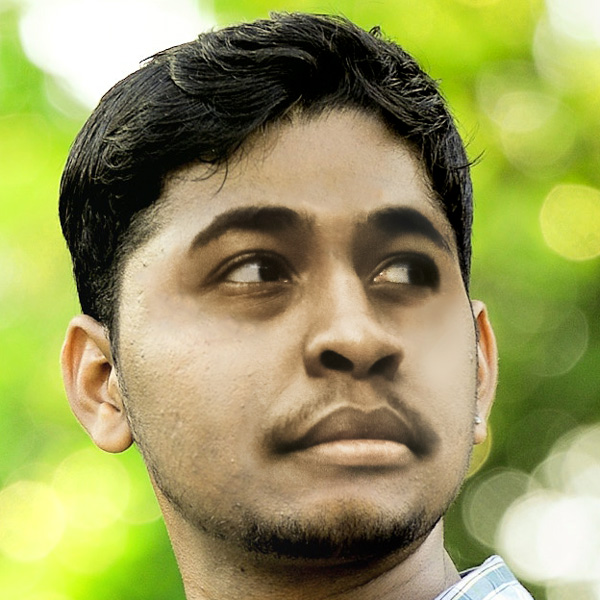

In [ ]:
# sample Image of original features - 600x600x3
Image.open(dataset.iloc[0]['Image_ID'])

In [ ]:
# shuffle the dataset 
dataset = dataset.sample(frac=1)

In [ ]:
# load images to new size of 64x64x3 and create numpy arrays to store images and labels
x_data = np.asarray([img_to_array(load_img(i, target_size=(n, n))) for i in dataset['Image_ID']])
y_data = np.asarray([np.asarray(i) for i in dataset['Label']])
y_data = y_data.astype(np.float32)

In [ ]:
# x_data = np.asarray([np.asarray(Image.open(i)) for i in dataset['Image_ID']])

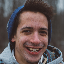

In [ ]:
# sample resized image
Image.fromarray(x_data[0].astype(np.uint8))

# Run

In [ ]:
# image data generator for augmenting the images using brightness, lateral flips, rotation and shifts along the x and y axes
datagen = ImageDataGenerator(brightness_range=[0.6,0.8], 
                             horizontal_flip=True, 
                             # vertical_flip=True,
                             rotation_range=30, 
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             # validation_split=0.2
                             )

train_gen = datagen.flow(x_data, y_data, batch_size=len(x_data))

In [ ]:
# augment the data by a factor of 10
x, y = train_gen.next()
y = y.reshape(2041, 1) 
for i in range(10):
  temp_x, temp_y = train_gen.next()
  temp_y = temp_y.reshape(2041, 1)
  x = np.vstack((x, temp_x))
  y = np.vstack((y, temp_y))

In [ ]:
# sample augmented images (flipped)

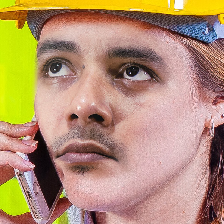

In [ ]:
Image.fromarray(x_train[0].astype(np.uint8))

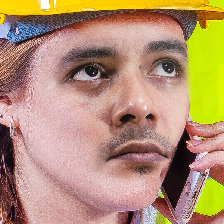

In [ ]:
Image.fromarray(x_train_flipped[0].astype(np.uint8))

In [ ]:
# training and testing splits when not using cross-validation
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# del x_train
# del x_test

In [ ]:
x.shape

(22451, 64, 64, 3)

In [ ]:
# loading previously trained best performing model
model = keras.models.load_model('/content/gdrive/MyDrive/Models/cnn_tl_4')

In [ ]:
# accuracy of 93% on new augmented data
model.evaluate(x,y)

702/702 [==============================] - 53s 34ms/step - loss: 0.2257 - accuracy: 0.9362


[0.22574390470981598, 0.9361721277236938]

# CNN-Very Deep

In [ ]:
# Printing model summary for very deep neural network
vgg = tf.keras.applications.VGG16(input_shape = (n, n, 3), include_top = False, weights = "imagenet")
averaging_layer = tf.keras.layers.Flatten()(vgg.output)
dense1 = tf.keras.layers.Dense(units = 1024, activation = 'relu')(averaging_layer)
bn = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(units = 1024, activation = 'relu')(bn)
dense3 = tf.keras.layers.Dense(units = 1024, activation = 'relu')(dense2)
dense4 = tf.keras.layers.Dense(units = 512, activation = 'relu')(dense3)
dense5 = tf.keras.layers.Dense(units = 512, activation = 'relu')(dense4)
dense6 = tf.keras.layers.Dense(units = 512, activation = 'relu')(dense5)
dense7 = tf.keras.layers.Dense(units = 256, activation = 'relu')(dense6)
dense8 = tf.keras.layers.Dense(units = 32, activation = 'relu')(dense7)
output = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')(dense8)
combined_model = tf.keras.models.Model(inputs = vgg.input, outputs = output)
combined_model.summary()
for i in range(4):
  combined_model.layers[i].trainable = False

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
# Training very deep neural network - 53.9% accuracy, does not learn useful features
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
vgg = tf.keras.applications.VGG16(input_shape = (n, n, 3), include_top = False, weights = "imagenet")
averaging_layer = tf.keras.layers.Flatten()(vgg.output)
dense1 = tf.keras.layers.Dense(units = 1024, activation = 'relu')(averaging_layer)
bn = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(units = 1024, activation = 'relu')(bn)
dense3 = tf.keras.layers.Dense(units = 1024, activation = 'relu')(dense2)
dense4 = tf.keras.layers.Dense(units = 512, activation = 'relu')(dense3)
dense5 = tf.keras.layers.Dense(units = 512, activation = 'relu')(dense4)
dense6 = tf.keras.layers.Dense(units = 512, activation = 'relu')(dense5)
dense7 = tf.keras.layers.Dense(units = 256, activation = 'relu')(dense6)
dense8 = tf.keras.layers.Dense(units = 32, activation = 'relu')(dense7)
output = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')(dense8)
combined_model = tf.keras.models.Model(inputs = vgg.input, outputs = output)
combined_model.summary()
for i in range(4):
  combined_model.layers[i].trainable = False
combined_model.compile(loss="binary_crossentropy", optimizer='adam', metrics = ['accuracy'])
hist = combined_model.fit(
	x_train, y_train,
  validation_data=(x_test, y_test),
  epochs = 100,
  callbacks = [callback]
  )

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

# CNN-Deep+Transfer Learning

In [ ]:
# Training model with transfer learning - best performing with 93% accuracy
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
vgg = tf.keras.applications.VGG16(input_shape = (n, n, 3), include_top = False, weights = "imagenet")
averaging_layer = tf.keras.layers.Flatten()(vgg.output)
dense1 = tf.keras.layers.Dense(units = 512, activation = 'relu')(averaging_layer)
bn = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(units = 512, activation = 'relu')(bn)
dense3 = tf.keras.layers.Dense(units = 256, activation = 'relu')(dense2)
dense4 = tf.keras.layers.Dense(units = 32, activation = 'relu')(dense3)
output = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')(dense4)
combined_model = tf.keras.models.Model(inputs = vgg.input, outputs = output)
combined_model.summary()
for i in range(4):
  combined_model.layers[i].trainable = False
combined_model.compile(loss="binary_crossentropy", optimizer='adam', metrics = ['accuracy'])
hist = combined_model.fit(
	x_train, y_train,
  validation_data=(x_test, y_test),
  epochs = 100,
  callbacks = [callback]
  )

58900480/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

[[1404  101]
 [ 127 1634]]


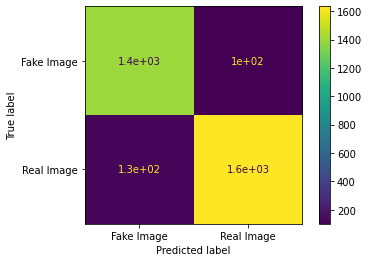

In [ ]:
# plotting architectures and confusion matrices - notice generally higher recall/sensitivity
plot_model(combined_model, to_file='model_tl.png', show_shapes=True, show_layer_names=False)

def sigmoid(x):
  if x>0.5:
    return 1
  else:
    return 0 

pred = np.asarray([sigmoid(i[0]) for i in combined_model.predict(x_test)])
conf = confusion_matrix(y_test, pred)
print(conf)
conf = ConfusionMatrixDisplay(conf, ["Fake Image", "Real Image"])
conf.plot()
plt.show()

In [ ]:
combined_model.save('/content/gdrive/MyDrive/Models/cnn_tl_4')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Models/cnn_tl_4/assets


In [ ]:
# Verification of best performing model using 5-fold cross validation - averaged 88.94% accuracy across the folds
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)
acc_per_fold = []
loss_per_fold = []
hist_per_fold = []

for train, test in kfold.split(x, y):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
  vgg = tf.keras.applications.VGG16(input_shape = (n, n, 3), include_top = False, weights = "imagenet")
  averaging_layer = tf.keras.layers.Flatten()(vgg.output)
  dense1 = tf.keras.layers.Dense(units = 512, activation = 'relu')(averaging_layer)
  bn = tf.keras.layers.BatchNormalization()(dense1)
  dense2 = tf.keras.layers.Dense(units = 512, activation = 'relu')(bn)
  dense3 = tf.keras.layers.Dense(units = 256, activation = 'relu')(dense2)
  dense4 = tf.keras.layers.Dense(units = 32, activation = 'relu')(dense3)
  output = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')(dense4)
  combined_model = tf.keras.models.Model(inputs = vgg.input, outputs = output)
  combined_model.summary()
  for i in range(4):
    combined_model.layers[i].trainable = False
  combined_model.compile(loss="binary_crossentropy", optimizer='adam', metrics = ['accuracy'])
  hist = combined_model.fit(
    x[train], y[train],
    validation_data = (x[test], y[test]),
    epochs = 100,
    callbacks = [callback]
    )
  
  scores = combined_model.evaluate(x[test], y[test], verbose=0)
  acc_per_fold.append(scores[1])
  loss_per_fold.append(scores[0])
  hist_per_fold.append(hist)
  gc.collect()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

# CNN-Shallow

In [ ]:
# shallow cnn model - 55%
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=1, activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 batch_normalization (BatchN  (None, 65536)            262144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 65537     
                                                                 
Total params: 329,473
Trainable params: 198,401
Non-trai

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(units=1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
hist_shallow = model.fit(
	x_train, y_train,
  validation_data=(x_test, y_test),
  epochs = 1000,
  callbacks = [callback]
  )

Epoch 1/1000
919/919 [==============================] - 5s 5ms/step - loss: 1.0991 - accuracy: 0.5462 - val_loss: 1.2754 - val_accuracy: 0.5058
Epoch 2/1000
919/919 [==============================] - 5s 5ms/step - loss: 0.7434 - accuracy: 0.5883 - val_loss: 1.2974 - val_accuracy: 0.5361
Epoch 3/1000
919/919 [==============================] - 5s 5ms/step - loss: 0.6990 - accuracy: 0.5894 - val_loss: 1.7361 - val_accuracy: 0.5530
Epoch 4/1000
919/919 [==============================] - 5s 5ms/step - loss: 0.7812 - accuracy: 0.5838 - val_loss: 1.5317 - val_accuracy: 0.5386
Epoch 5/1000
919/919 [==============================] - 5s 5ms/step - loss: 0.7081 - accuracy: 0.6065 - val_loss: 1.8494 - val_accuracy: 0.5266
Epoch 6/1000
919/919 [==============================] - 5s 5ms/step - loss: 0.7262 - accuracy: 0.6058 - val_loss: 1.7417 - val_accuracy: 0.5346
Epoch 7/1000
919/919 [==============================] - 5s 5ms/step - loss: 0.6825 - accuracy: 0.6283 - val_loss: 1.9925 - val_accuracy:

[[ 548  996]
 [ 463 1259]]


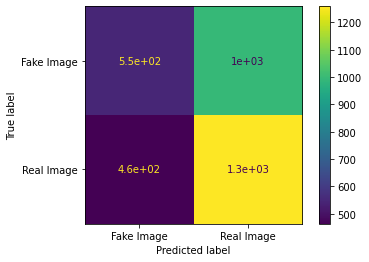

In [ ]:
plot_model(model, to_file='model_shallow.png', show_shapes=True, show_layer_names=False)

def sigmoid(x):
  if x>0.5:
    return 1
  else:
    return 0 

pred = np.asarray([sigmoid(i[0]) for i in model.predict(x_test)])
conf = confusion_matrix(y_test, pred)
print(conf)
conf = ConfusionMatrixDisplay(conf, ["Fake Image", "Real Image"])
conf.plot()
plt.show()

In [ ]:
model.save('/content/gdrive/MyDrive/Models/cnn_shallow')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Models/cnn_shallow/assets


# CNN-Mid-Depth

In [ ]:
# mid depth cnn - 69.4%
model2 = keras.models.Sequential()
model2.add(keras.layers.Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(units=512,activation="relu"))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dense(units=32,activation="relu"))
model2.add(keras.layers.Dense(units=1, activation="sigmoid"))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                      

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

model2 = keras.models.Sequential()
model2.add(keras.layers.Conv2D(input_shape=(64,64,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(units=512,activation="relu"))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dense(units=32,activation="relu"))
model2.add(keras.layers.Dense(units=1, activation="sigmoid"))
model2.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
model2.fit(
	x_train, y_train,
  validation_data=(x_test, y_test),
  epochs = 1000,
  callbacks = [callback]
  )

Epoch 1/1000
919/919 [==============================] - 34s 19ms/step - loss: 0.6950 - accuracy: 0.5570 - val_loss: 0.7397 - val_accuracy: 0.5493
Epoch 2/1000
919/919 [==============================] - 17s 18ms/step - loss: 0.6698 - accuracy: 0.5834 - val_loss: 1.8465 - val_accuracy: 0.5882
Epoch 3/1000
919/919 [==============================] - 17s 18ms/step - loss: 0.6610 - accuracy: 0.5975 - val_loss: 0.6972 - val_accuracy: 0.5909
Epoch 4/1000
919/919 [==============================] - 17s 18ms/step - loss: 0.6547 - accuracy: 0.6077 - val_loss: 0.6848 - val_accuracy: 0.5888
Epoch 5/1000
919/919 [==============================] - 17s 18ms/step - loss: 0.6453 - accuracy: 0.6237 - val_loss: 0.6742 - val_accuracy: 0.5968
Epoch 6/1000
919/919 [==============================] - 17s 18ms/step - loss: 0.6248 - accuracy: 0.6451 - val_loss: 0.6522 - val_accuracy: 0.6341
Epoch 7/1000
919/919 [==============================] - 17s 18ms/step - loss: 0.5937 - accuracy: 0.6755 - val_loss: 0.6507 -

[[ 962  582]
 [ 417 1305]]


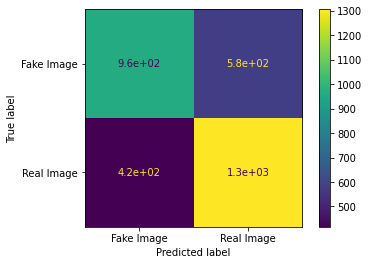

In [ ]:
plot_model(model2, to_file='model_middepth.png', show_shapes=True, show_layer_names=False)

def sigmoid(x):
  if x>0.5:
    return 1
  else:
    return 0 

pred = np.asarray([sigmoid(i[0]) for i in model2.predict(x_test)])
conf = confusion_matrix(y_test, pred)
print(conf)
conf = ConfusionMatrixDisplay(conf, ["Fake Image", "Real Image"])
conf.plot()
plt.show()

In [ ]:
model2.save('/content/gdrive/MyDrive/Models/cnn_middepth')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Models/cnn_middepth/assets


# CNN-Deep

In [ ]:
# deep cnn - 74.3%
model3 = keras.models.Sequential()
model3.add(keras.layers.Conv2D(input_shape=(64,64,3),filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model3.add(keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(units=512,activation="relu"))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Dense(units=512,activation="relu"))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Dense(units=128,activation="relu"))
model3.add(keras.layers.Dropout(0.5))
model3.add(keras.layers.Dense(units=32,activation="relu"))
model3.add(keras.layers.Dense(units=1, activation="sigmoid"))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 128)       3584      
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                  

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

model3 = keras.models.Sequential()
model3.add(keras.layers.Conv2D(input_shape=(64,64,3),filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model3.add(keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model3.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(units=512,activation="relu"))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Dense(units=512,activation="relu"))
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Dense(units=128,activation="relu"))
model3.add(keras.layers.Dropout(0.5))
model3.add(keras.layers.Dense(units=32,activation="relu"))
model3.add(keras.layers.Dense(units=1, activation="sigmoid"))
model3.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
hist_deep = model3.fit(
	x_train, y_train,
  validation_data=(x_test, y_test),
  epochs = 1000,
  callbacks = [callback]
  )

Epoch 1/1000
919/919 [==============================] - 20s 21ms/step - loss: 0.7218 - accuracy: 0.5314 - val_loss: 0.8224 - val_accuracy: 0.5236
Epoch 2/1000
919/919 [==============================] - 18s 20ms/step - loss: 0.6856 - accuracy: 0.5528 - val_loss: 0.7085 - val_accuracy: 0.5367
Epoch 3/1000
919/919 [==============================] - 18s 20ms/step - loss: 0.6823 - accuracy: 0.5587 - val_loss: 0.6875 - val_accuracy: 0.5447
Epoch 4/1000
919/919 [==============================] - 18s 20ms/step - loss: 0.6801 - accuracy: 0.5644 - val_loss: 0.6863 - val_accuracy: 0.5527
Epoch 5/1000
919/919 [==============================] - 18s 20ms/step - loss: 0.6757 - accuracy: 0.5722 - val_loss: 0.6739 - val_accuracy: 0.5732
Epoch 6/1000
919/919 [==============================] - 18s 20ms/step - loss: 0.6653 - accuracy: 0.5954 - val_loss: 1.2244 - val_accuracy: 0.5352
Epoch 7/1000
919/919 [==============================] - 18s 20ms/step - loss: 0.6636 - accuracy: 0.5984 - val_loss: 0.7118 -

[[1115  429]
 [ 411 1311]]


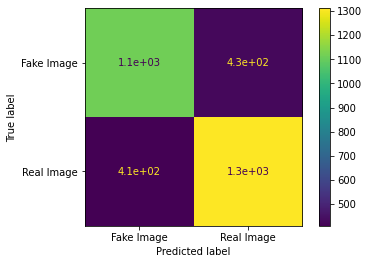

In [ ]:
plot_model(model3, to_file='model_deep.png', show_shapes=True, show_layer_names=False)

def sigmoid(x):
  if x>0.5:
    return 1
  else:
    return 0 

pred = np.asarray([sigmoid(i[0]) for i in model3.predict(x_test)])
conf = confusion_matrix(y_test, pred)
print(conf)
conf = ConfusionMatrixDisplay(conf, ["Fake Image", "Real Image"])
conf.plot()
plt.show()

In [ ]:
model3.save('/content/gdrive/MyDrive/Models/cnn_deep')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Models/cnn_deep/assets


# Experimental/Miscellaneous

In [ ]:
np.argmax(model2.predict(x_test), axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
def sigmoid(x):
  if x>0.5:
    return 1
  else:
    return 0 

pred = np.asarray([sigmoid(i[0]) for i in model2.predict(x_test)])
confusion_matrix(y_test, pred)

In [ ]:
confusion_matrix(y_test, pred)

array([[ 989,  553],
       [ 624, 1100]])

In [ ]:
model2.save('/content/gdrive/MyDrive/Models/CNN_4conv_2dense')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Models/CNN_4conv_2dense/assets


In [ ]:
# del x
# del y
# import gc
# gc.collect()

# callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25)
# vgg = tf.keras.applications.VGG16(input_shape = (n, n, 3), include_top = True, weights = "imagenet")
# model = tf.keras.models.Sequential()
# # num_layers = 7
# for layer in vgg.layers[:-1]:
#   model.add(layer)
# model.trainable = False
# model.add(keras.layers.Dense(units=1, activation="sigmoid"))
# model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
# model.fit(
# 	x_train, y_train,
#   validation_data=(x_test, y_test),
#   epochs = 1000,
#   callbacks = [callback]
#   )

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25)

model2 = keras.models.Sequential()
model2.add(keras.layers.Conv2D(input_shape=(64,64,3),filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(units=512,activation="relu"))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dense(units=512,activation="relu"))
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dense(units=128,activation="relu"))
model2.add(keras.layers.Dropout(0.5))
model2.add(keras.layers.Dense(units=32,activation="relu"))
model2.add(keras.layers.Dense(units=1, activation="sigmoid"))
model2.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics = ['accuracy'])
hist = model2.fit(
	x_train, y_train,
  validation_data=(x_test, y_test),
  epochs = 1000,
  callbacks = [callback]
  )

Epoch 1/1000
919/919 [==============================] - 19s 20ms/step - loss: 0.7236 - accuracy: 0.5323 - val_loss: 0.6922 - val_accuracy: 0.5334
Epoch 2/1000
919/919 [==============================] - 18s 19ms/step - loss: 0.6822 - accuracy: 0.5610 - val_loss: 0.6781 - val_accuracy: 0.5753
Epoch 3/1000
919/919 [==============================] - 18s 19ms/step - loss: 0.6758 - accuracy: 0.5718 - val_loss: 0.7146 - val_accuracy: 0.5282
Epoch 4/1000
919/919 [==============================] - 18s 19ms/step - loss: 0.6730 - accuracy: 0.5770 - val_loss: 0.6851 - val_accuracy: 0.5695
Epoch 5/1000
919/919 [==============================] - 18s 19ms/step - loss: 0.6684 - accuracy: 0.5911 - val_loss: 0.6917 - val_accuracy: 0.5536
Epoch 6/1000
919/919 [==============================] - 18s 19ms/step - loss: 0.6627 - accuracy: 0.5991 - val_loss: 0.6649 - val_accuracy: 0.6066
Epoch 7/1000
919/919 [==============================] - 18s 19ms/step - loss: 0.6630 - accuracy: 0.6003 - val_loss: 0.6929 -

In [ ]:
model2.save('/content/gdrive/MyDrive/Models/CNN_Augmented_noTL_2')

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Models/CNN_Augmented_noTL_2/assets


In [ ]:
hist

In [ ]:
import pickle

with open('/content/gdrive/MyDrive/Models/history.pickle', 'wb') as file:
    pickle.dump(hist, file)

In [ ]:
np.unique(x, axis=0).shape

(32656, 64, 64, 3)

In [ ]:
del x
del y

In [ ]:
y.shape

(10205, 1)

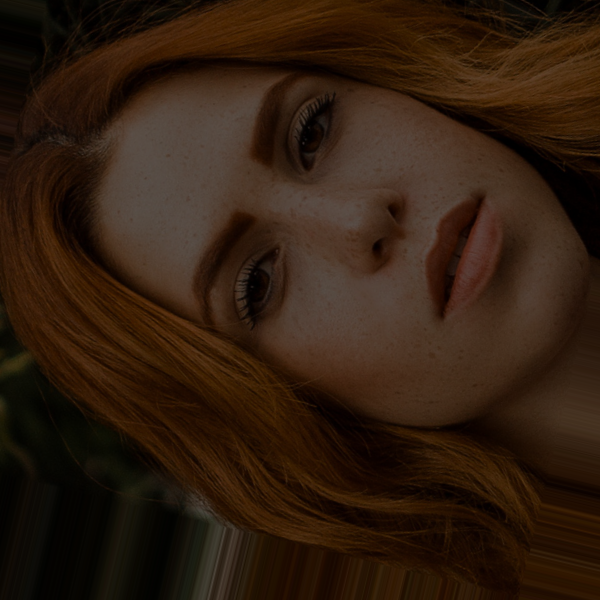

In [ ]:
Image.fromarray(x[4].astype(np.uint8))

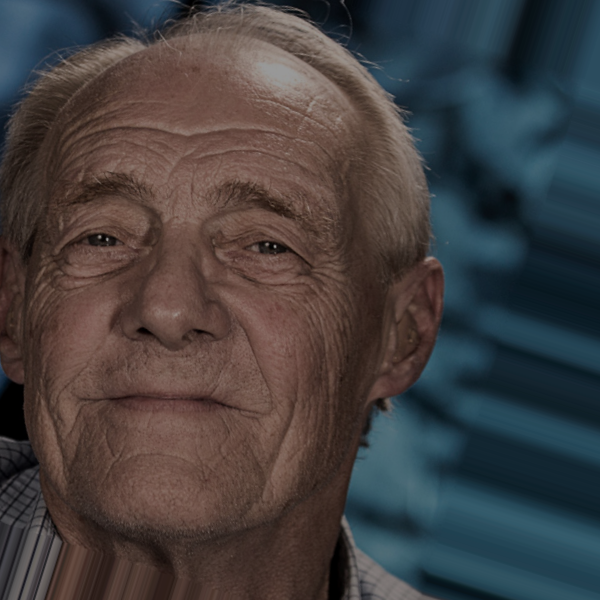

In [ ]:
Image.fromarray(train_gen.next()[0][0].astype(np.uint8))

In [ ]:
vgg = tf.keras.applications.VGG16(input_shape = (n, n, 3), include_top = False, weights = "imagenet")
averaging_layer = tf.keras.layers.Flatten()(vgg.output)
dense1 = tf.keras.layers.Dense(units = 512, activation = 'relu')(averaging_layer)
bn = tf.keras.layers.BatchNormalization()(dense1)
dense2 = tf.keras.layers.Dense(units = 512, activation = 'relu')(bn)
dense3 = tf.keras.layers.Dense(units = 256, activation = 'relu')(dense2)
dense4 = tf.keras.layers.Dense(units = 32, activation = 'relu')(dense3)
output = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')(dense4)
combined_model = tf.keras.models.Model(inputs = vgg.input, outputs = output)
combined_model.summary()
combined_model.compile(loss="binary_crossentropy", optimizer='adam', metrics = ['accuracy'])
combined_model.fit(
	x_train, y_train,
  validation_data=(x_test, y_test),
  epochs = 100,
  callbacks = [callback]
  )


In [ ]:
model = tf.keras.models.Sequential()
num_layers = 7
for layer in vgg.layers[:num_layers]:
  model.add(layer)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
Total params: 260,160
Trainable params: 260,160
Non-trainable params: 0
________________________________________________

In [ ]:
# model.trainable = False

In [ ]:
model.add(tf.keras.layers.Conv2D(filters = 256, activation = 'relu', kernel_size=(3,3)))
model.add(tf.keras.layers.Conv2D(filters = 256, activation = 'relu', kernel_size=(3,3)))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(tf.keras.layers.GlobalMaxPool2D())
model.add(tf.keras.layers.Dense(units = 512, activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units = 512, activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units = 32, activation = 'relu'))
model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))

In [ ]:
model.summary()
for i in model.layers:
  print(i.trainable)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 54, 54, 256)      

In [ ]:
model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy'])
model.fit(
	train_gen,
  validation_data=validation_gen,
  epochs = 100,
  # callbacks = [callback]
  )

In [ ]:
averaging_layer = tf.keras.layers.GlobalAveragePooling2D()(vgg.output)
dense1 = tf.keras.layers.Dense(units = 512, activation = 'relu')(averaging_layer)
dense2 = tf.keras.layers.Dense(units = 512, activation = 'relu')(dense1)
dense3 = tf.keras.layers.Dense(units = 256, activation = 'relu')(dense2)
dense4 = tf.keras.layers.Dense(units = 256, activation = 'relu')(dense3)
output = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')(dense4)
combined_model = tf.keras.models.Model(inputs = vgg.input, outputs = output)
combined_model.summary()
combined_model.compile(loss="binary_crossentropy", optimizer='adam', metrics = ['accuracy'])
combined_model.fit(
	train_gen,
  validation_data=(x_test, y_test),
  epochs = 100,
  callbacks = [callback]
  )

In [ ]:
combined_model = tf.keras.models.Model(inputs = vgg.input, outputs = output)
combined_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 600, 600, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 600, 600, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 600, 600, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 300, 300, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 300, 300, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 300, 300, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 150, 150, 128)     0   

In [ ]:
for i in range(10):
  combined_model.layers[i].trainable = False

In [ ]:
combined_model.compile(loss="binary_crossentropy", optimizer='adam', metrics = ['accuracy'])
combined_model.fit(
	train_gen,
  validation_data=(x_test, y_test),
  epochs = 100,
  callbacks = [callback]
  )

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model2 = keras.models.Sequential()
model2.add(keras.layers.Conv2D(input_shape=(64,64,3),filters=128,kernel_size=(3,3),padding="same", activation="relu", name="conv1", strides=(2,2)))
model2.add(keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu", name="conv2", strides=(2,2)))
model2.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", name="conv3", strides=(2,2)))
model2.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", name="conv4", strides=(2,2)))
# model2.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2), name="pool1"))
# model2.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", name="conv4", strides=(2,2)))
# model2.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu", name="conv5", strides=(2,2)))
model2.add(keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2), name="pool2"))
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(units=512,activation="relu",name="dense1"))
model2.add(keras.layers.Dense(units=512,activation="relu",name="dense2"))
model2.add(keras.layers.Dense(units=128,activation="relu",name="dense3"))
model2.add(keras.layers.Dense(units=32,activation="relu",name="dense4"))
model2.add(keras.layers.Dense(units=1, activation="sigmoid",name="dense5"))
model2.compile(loss="binary_crossentropy", optimizer='adam', metrics = ['accuracy'])
model2.fit(
	x_train, y_train,
  validation_data=(x_test, y_test),
  epochs = 100,
  callbacks = [callback]
  )

Epoch 1/100
664/664 [==============================] - 6s 8ms/step - loss: 0.6997 - accuracy: 0.5253 - val_loss: 0.6911 - val_accuracy: 0.5293
Epoch 2/100
664/664 [==============================] - 5s 8ms/step - loss: 0.6916 - accuracy: 0.5289 - val_loss: 0.6911 - val_accuracy: 0.5293
Epoch 3/100
664/664 [==============================] - 5s 8ms/step - loss: 0.6916 - accuracy: 0.5308 - val_loss: 0.6913 - val_accuracy: 0.5293
Epoch 4/100
664/664 [==============================] - 5s 8ms/step - loss: 0.6919 - accuracy: 0.5281 - val_loss: 0.6920 - val_accuracy: 0.5212
Epoch 5/100
664/664 [==============================] - 5s 8ms/step - loss: 0.6926 - accuracy: 0.5287 - val_loss: 0.6913 - val_accuracy: 0.5293
Epoch 6/100
664/664 [==============================] - 5s 8ms/step - loss: 0.6916 - accuracy: 0.5292 - val_loss: 0.6915 - val_accuracy: 0.5293
Epoch 7/100
664/664 [==============================] - 5s 8ms/step - loss: 0.6917 - accuracy: 0.5288 - val_loss: 0.6912 - val_accuracy: 0.5293

In [ ]:
x_train = np.vstack((x_train, np.asarray([np.fliplr(i) for i in x_train])))
x_train = np.vstack((x_train, np.asarray([np.flipud(i) for i in x_train])))

In [ ]:
# y_train = y_train.reshape(1530, 1)

In [ ]:
y_train = np.vstack((y_train, y_train))
y_train = np.vstack((y_train, y_train))

In [ ]:
x_train.shape

(6120, 64, 64, 3)

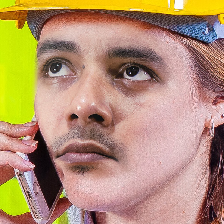

In [ ]:
Image.fromarray(x_train[0].astype(np.uint8))

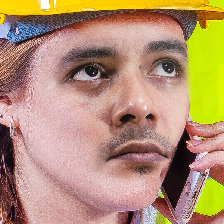

In [ ]:
Image.fromarray(x_train_flipped[0].astype(np.uint8))

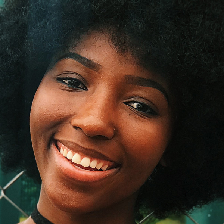

In [ ]:
Image.fromarray(np.fliplr(x_train[1529]).astype(np.uint8))

In [ ]:
enc = OneHotEncoder(sparse=False).fit(y_train.reshape(y_train.shape[0], 1))

In [ ]:
y_train = enc.transform(y_train.reshape(y_train.shape[0], 1))

In [ ]:
y_test = enc.transform(y_test.reshape(y_test.shape[0], 1))

In [ ]:
y_train[0]

array([0., 1.])

In [ ]:
pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-_4mme1sf
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-_4mme1sf
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=94da915d2566b538b34858ea6898cd2b3d7eb567d974de8557c701bba318d90b
  Stored in directory: /tmp/pip-ephem-wheel-cache-k6k20nx_/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface


In [ ]:
pip show keras-vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: pyyaml, h5py, six, scipy, pillow, keras, numpy
Required-by: 


In [ ]:
pip install keras_applications

     |████████████████████████████████| 50 kB 3.2 MB/s 


In [ ]:
import keras_applications
import keras_vggface